<a href="https://colab.research.google.com/github/ArslanAmanov/AI-ML-DL/blob/default-branch/Kaggle%20Projects%20/UCI%20ML%20drug%20dataset/uci_ml%20drug%20test%20project%20NLP_multiclass%20classific.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [8]:
# !pip install torch torchvision

In [7]:
# import torch

# if torch.cuda.is_available():
#     !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# else:
#     print("No GPU available.")

In [9]:
# import torch
# import torchvision

# print(torch.__version__)
# print(torchvision.__version__)

In [6]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
from functools import partial
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [10]:
#UCI ML drug dataset

#Importing the datasets and libraries
url_1_test='https://raw.githubusercontent.com/ArslanAmanov/AI-ML-DL/default-branch/Kaggle%20Projects%20/UCI%20ML%20drug%20dataset/drugsComTest_raw.csv'
url_2_train='https://raw.githubusercontent.com/ArslanAmanov/AI-ML-DL/default-branch/Kaggle%20Projects%20/UCI%20ML%20drug%20dataset/drugsComTrain_raw.csv'
df1 = pd.read_csv(url_1_test)
df2 = pd.read_csv(url_2_train)

In [11]:
data = pd.concat([df1,df2])[['review','condition']]

In [12]:
data.head()

,review,condition
0,"""I&#039;ve tried a few antidepressants over th...",Depression
1,"""My son has Crohn&#039;s disease and has done ...","Crohn's Disease, Maintenance"
2,"""Quick reduction of symptoms""",Urinary Tract Infection
3,"""Contrave combines drugs that were used for al...",Weight Loss
4,"""I have been on this birth control for one cyc...",Birth Control


In [13]:
#remove Null values from data
data =data[pd.notnull(data['review'])]

# Finding the maxlen

In [14]:
data['len'] = data['review'].apply(lambda a :len(a))

<Axes: ylabel='Frequency'>

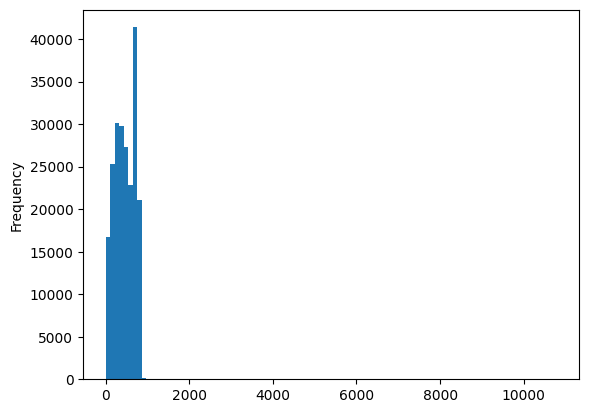

In [15]:
data['len'].plot.hist(bins=100)

In [16]:
data.len.quantile(0.9)

758.0

# Preprocessing Y column
we are only going to be classifying conditions for which the count of reviews are more than 3000

In [17]:
count_df = data[['condition', 'review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review', ascending=False)
count_df.head()

,condition,review
175,Birth Control,38436
273,Depression,12164
613,Pain,8245
133,Anxiety,7812
87,Acne,7435


In [19]:
target_conditions = count_df[count_df['review']>3000]['condition'].values

In [20]:
def condition_parser(x):
  if x in target_conditions:
    return x
  else:
    return "OTHER"
data['condition'] = data['condition'].apply(lambda x: condition_parser(x))

In [22]:
data=data[data['condition']!='OTHER']
import plotly.express as px


In [23]:
px.bar(count_df[count_df['review']>3000], x='condition', y='review')

In [24]:
import re

def clean_text(x):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', x)
  return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [25]:
contraction_dict = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
    "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
    "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is",
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [37]:
# lower the text

data["review"] = data["review"].apply(lambda x:x.lower())

#clean the text
data["review"] = data["review"].apply(lambda x:clean_text(x))

#clean numbers
data["review"] = data["review"].apply(lambda x: clean_numbers(x))

#clean contractions
data["review"] = data["review"].apply(lambda x:replace_contractions(x))

In [38]:
data['condition'].unique()

array(['Depression', 'Weight Loss', 'Birth Control',
       'Vaginal Yeast Infection', 'Insomnia', 'Acne', 'Bipolar Disorde',
       'Diabetes, Type 2', 'Pain', 'Emergency Contraception', 'Anxiety',
       'ADHD', 'Obesity', 'High Blood Pressure'], dtype=object)

In [39]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['review'], data['condition'], stratify=data['condition'], test_size=0.25)

In [40]:
print("Train shape : ", train_X.shape)
print("Test shape : ", test_X.shape)

Train shape :  (83673,)
Test shape :  (27891,)


# Basic Parameters

In [41]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 750  # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5   # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED=10
debug=0

In [42]:
# Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))

train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

##Pad the sentences
train_X = pad_sequences(train_X, maxlen=max_len)
test_X = pad_sequences(test_X, maxlen=max_len)

In [43]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [44]:
le.classes_

array(['ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde', 'Birth Control',
       'Depression', 'Diabetes, Type 2', 'Emergency Contraception',
       'High Blood Pressure', 'Insomnia', 'Obesity', 'Pain',
       'Vaginal Yeast Infection', 'Weight Loss'], dtype=object)